# First, let's load the MNIST dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import requests # for alpha-binary digits

# import torch
# from torchvision import datasets, transforms # for MNIST

ModuleNotFoundError: No module named 'torch'

### Downloading, preprocessing & loading MNIST

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('../data/processed', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test data
testset = datasets.MNIST('../data/processed', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [ ]:
dataiter = iter(trainloader)

In [ ]:
images, labels = dataiter.next()

In [ ]:
print(images.shape, labels.shape) #loading 64 images of shape 28x28

torch.Size([64, 1, 28, 28]) torch.Size([64])


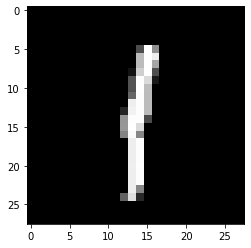

In [ ]:
plt.imshow(images[0].squeeze(), cmap='Greys_r')

---

### Downloading AlphaBinary

In [7]:
# alpha_binary_mat = requests.get('https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat')

In [8]:
# with open('../data/raw/alpha_binary.mat', 'wb') as f:
    # f.write(alpha_binary_mat.content)

### Preprocessing AlphaBinary

In [4]:
import scipy.io

In [5]:
file_mat = '../data/raw/alpha_binary.mat'
mat = scipy.io.loadmat(file_mat)

In [6]:
type(mat)

dict

In [7]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [8]:
mat['dat'].shape # 39 samples for each of the 36 classes - 10 digits & 26 letters

(36, 39)

In [9]:
mat['classlabels'][0]

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

In [10]:
labels = np.array([label.item() for label in mat['classlabels'][0]])

In [11]:
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

---

In [12]:
images = mat['dat']

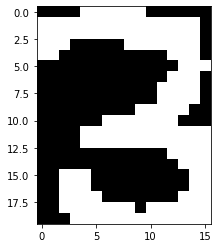

In [13]:
plt.imshow(images[3][0], cmap='Greys_r')

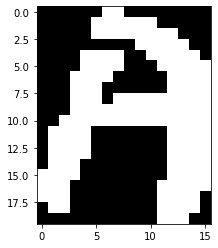

In [14]:
plt.imshow(images[10][0], cmap='Greys_r')

In [15]:
labels_array = []

In [16]:
for index, classe in enumerate(images):
    for image in classe:
        labels_array.append(labels[index])

labels_array = np.array(labels_array)

In [17]:
labels_array.shape[0] == 36*39

True

In [18]:
labels_array[0], labels_array[38], labels_array[39]

('0', '0', '1')

---

In [19]:
images[0][0].flatten().shape

(320,)

In [20]:
images[0][0].shape

(20, 16)

In [21]:
def lire_alpha_digit(all_images, classes:list):
    data = []
    for cls in classes:
        for image in all_images[cls]:
            data.append(image.flatten().reshape(-1,1))
    
    return np.array(data)

All our data has been loaded and is ready to be used in a python data environment !

---

# Creating NN classes & methods
### RBM

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [23]:
def logistic(x,w,b):
   xw = np.dot(x, w)
   replicated_b = np.tile(b, (x.shape[0], 1))

   return 1.0 / (1 + np.exp(- xw - b))

In [24]:
class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        self.W = W if W is not None else np.random.uniform(-1, 1, size=shape)
        self.b = b if b is not None else np.zeros(n_v)
        self.c = c if c is not None else np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs
    
    def train_model(self, train_data, n_epoch=100, batch_size=10, learning=0.01):
        for _ in range(n_epoch):
            MSE = []
            data = train_data.copy()
            np.random.shuffle(data)
            for x in data:
                self.contrastive_divergence(x.T, learning)
                reconstructed = self.reconstruct(x.T)
                MSE.append(((x.T - reconstructed)**2).sum()/len(x))
            print(f'MSE for epoch {_}: {np.array(MSE).mean()}')                      
        return
    
    def generate_image(self, iter_gibbs, number_image):
        images = []
        for _ in range(number_image):
            v = np.zeros(self.n_v).reshape(1, -1)
            for _ in range(iter_gibbs):
                _, v = self.reconstruct(v)
            images.append(v)
        return images

---

In [27]:
rbm = RBM(20*16, 20*8)

In [28]:
data = lire_alpha_digit(images, [0, 1, 2])

In [29]:
# train_data = list(zip(data, labels_array[:39*3]))

In [30]:
rbm.train_model(data, n_epoch=300)

MSE for epoch 0: 0.4319331750591681
MSE for epoch 1: 0.3614230211788333
MSE for epoch 2: 0.3213852960073422
MSE for epoch 3: 0.29636541179495807
MSE for epoch 4: 0.2799738540656677
MSE for epoch 5: 0.2622202961537549
MSE for epoch 6: 0.24985763423291468
MSE for epoch 7: 0.2370433076905137
MSE for epoch 8: 0.2331360712693306
MSE for epoch 9: 0.2211448645646698
MSE for epoch 10: 0.21528874182486127
MSE for epoch 11: 0.20484305284210239
MSE for epoch 12: 0.1966981152293319
MSE for epoch 13: 0.19226622565619983
MSE for epoch 14: 0.1884218012201715
MSE for epoch 15: 0.18419116391020296
MSE for epoch 16: 0.1807247391993347
MSE for epoch 17: 0.17275727606352637
MSE for epoch 18: 0.16740586196033774
MSE for epoch 19: 0.16353921909159647
MSE for epoch 20: 0.16226351316872653
MSE for epoch 21: 0.15775539508097836
MSE for epoch 22: 0.15592087276521002
MSE for epoch 23: 0.14987356556853845
MSE for epoch 24: 0.14384707375119798
MSE for epoch 25: 0.14260554939893055
MSE for epoch 26: 0.1407739197266

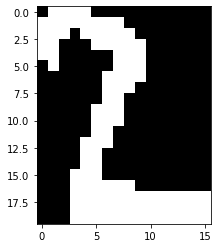

In [31]:
plt.imshow(data[39*2].reshape(20,16), cmap='Greys_r')

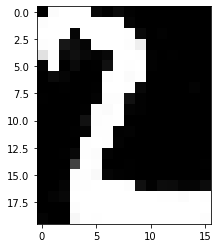

In [32]:
plt.imshow(rbm.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')

In [33]:
generated_images = rbm.generate_image(iter_gibbs=1000, number_image=100)

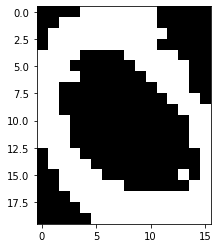

In [34]:
plt.imshow(generated_images[39].reshape(20,16), cmap='Greys_r')

---

### DBN

In [40]:
class DBN():
    def __init__(self, n_v, layers, k=1):
        
        if n_v is None or layers is None: raise ValueError("Incorrect inputs for layer 0.")
        
        n_hs = [n_v]        
        n_layer = 0
        # training_done = True
        rbms = []
        for (n_h, model) in layers:
            n_layer += 1
            if n_h <= 0: raise ValueError("Incorrect inputs for layer %d" % (n_layer))
            else: n_hs.append(n_h)

            rbm = RBM(n_hs[n_layer-1], n_h, k=k)
            # training_done = False
            rbms.append(rbm)

        self.n_hs = n_hs
        self.n_layer = n_layer
        # self.training_done = training_done
        self.rbms = rbms
        return
    
    def forward(self, X):
        # assert self.training_done
        
        Hp = X
        for i in range(self.n_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        return Hp, Hs

    def backward(self, H):
        # assert self.training_done

        Vp = H
        for i in reversed(range(self.n_layer)):
            Vp, Vs = self.rbms[i].backward(Vp)
        
        return Vp, Vs

    # def train_1layer_1batch(self, V, layer):
    #     Hp = V
    #     for i in range(layer):
    #         Hp, Hs = self.rbms[i].forward(Hp)
        
    #     if layer==0: 
    #         self.rbms[layer].contrastive_divergence(Hp, self.learning)
    #     else:
    #         for j in range(5):
    #             Vs = np.random.binomial(1, Hp, size=Hp.shape)
    #             self.rbms[layer].contrastive_divergence(Vs, self.learning)
                
    #     return

    # def train_1layer(self, X, layer, epochs, batch_size=10, learning=0.01):
    #     # assert not self.rbms[layer].training_done
        
    #     self.learning = learning
    #     n_x = X.shape[0]
    #     n_batch = n_x//batch_size
    #     for e in range(epochs):
    #         for i in range(n_batch):
    #             s = i*batch_size
    #             V = X[s:s+batch_size]
    #             self.train_1layer_1batch(V, layer)

    #     # self.rbms[layer].training_done = True
    #     return
    
    # this is internal API for more complex network to use
    def train_model(self, X, epochs=1, batch_size=10, learning=0.01):
        
        for layer in range(self.n_layer):
            # if self.rbms[layer].training_done: continue
            self.rbms[layer].train_model(X, n_epoch=epochs, learning=learning)
            X = tupleself.rbms[layer].forward(X)
            # self.train_1layer(X, layer, epochs, batch_size, learning)
        
        return
    
    def reconstruct(self, X):
        h_layer = self.n_layer - 1
        Hp = X
        for i in range(h_layer):
            Hp, Hs = self.rbms[i].forward(Hp)
        
        Vp, Vs = self.rbms[h_layer].reconstruct(Hp)

        for i in reversed(range(h_layer)):
            Hp, Hs = self.rbms[i].backward(Hp)

        return Hp, Hs

In [41]:
n_v = 20*16
h_1 = 20*10
h_2 = 20*8
h_3 = 20*8

layers = [
    (h_1, None),
    (h_2, None),
    (h_3, None),
]

dbn = DBN(n_v, layers)

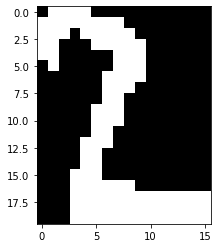

In [42]:
plt.imshow(data[39*2].T.reshape(20,16), cmap='Greys_r')

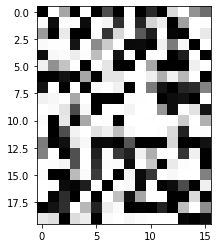

In [43]:
plt.imshow(dbn.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')

In [44]:
dbn.train_model(data, epochs=100)

MSE for epoch 0: 0.3967476903560114
MSE for epoch 1: 0.3144423083447578
MSE for epoch 2: 0.27775549906449115
MSE for epoch 3: 0.25885124859914166
MSE for epoch 4: 0.23840871352395426
MSE for epoch 5: 0.22814662326120227
MSE for epoch 6: 0.21165043465673217
MSE for epoch 7: 0.20242901539520705
MSE for epoch 8: 0.19584270848785243
MSE for epoch 9: 0.18633565750844744
MSE for epoch 10: 0.17980629868310352
MSE for epoch 11: 0.1726281739562483
MSE for epoch 12: 0.1665894320893549
MSE for epoch 13: 0.16100516259905523
MSE for epoch 14: 0.15724727758547188
MSE for epoch 15: 0.1527629265870576
MSE for epoch 16: 0.14688546325387722
MSE for epoch 17: 0.14430450549727428
MSE for epoch 18: 0.1386403149144094
MSE for epoch 19: 0.13323489186970364
MSE for epoch 20: 0.13203276327089902
MSE for epoch 21: 0.12885565844852528
MSE for epoch 22: 0.12403520889076994
MSE for epoch 23: 0.1222925488843357
MSE for epoch 24: 0.1191757662734246
MSE for epoch 25: 0.11613951291266612
MSE for epoch 26: 0.1128082628

ValueError: too many values to unpack (expected 2)

In [45]:
data.shape

(117, 320, 1)

In [65]:
np.array(list(map(lambda x : rbm.forward(x.T), data)))[0][0].shape

(1, 160)

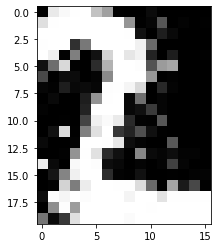

In [ ]:
plt.imshow(dbn.reconstruct(data[39*2].T)[0].reshape(20,16), cmap='Greys_r')